### Block 1
tuning, preprocessing and imports

In [ ]:
# ── Block 1 (revised) — imports, preprocessing & Keras Tuner ─────────────
# Uses LabelEncoder for *all* categorical columns; no One-Hot-Encoder.
# ------------------------------------------------------------------------

# 0. Imports
import json
import pathlib
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, regularizers, backend as K

# 1. Configuration
CSV_PATH = "modified_tedsa_data_clean.csv"
TARGET_COL = "SUB1"
SAMPLE_N = 343_000
VAL_SPLIT = 0.20
SEED = 43
TUNER_DIR = "tuner_logs"

# 2. Load sample & keep top-3 classes
df = (
    pd.read_csv(CSV_PATH)
    .sample(SAMPLE_N, random_state=SEED)
    .reset_index(drop=True)
)

top3 = df[TARGET_COL].value_counts().nlargest(3).index.tolist()
df = df[df[TARGET_COL].isin(top3)].reset_index(drop=True)

# 3. Encode labels
y_str = df[TARGET_COL]
le_target = LabelEncoder()
y = le_target.fit_transform(y_str)
n_classes = len(le_target.classes_)

# 4. Encode *every* feature column with LabelEncoder if it’s object / category
X_df = df.drop(columns=[TARGET_COL]).copy()
encoders = {}  # keep for inference / Block 2
for col in X_df.columns:
    if X_df[col].dtype == "object" or str(X_df[col].dtype).startswith("category"):
        le_col = LabelEncoder()
        X_df[col] = le_col.fit_transform(X_df[col].astype(str))
        encoders[col] = le_col

# Make sure everything is numeric and float32
X = X_df.astype(np.float32).values
input_dim = X.shape[1]

# 5. Train/val/test split  (same logic as before)
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X, y, test_size=VAL_SPLIT, stratify=y, random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=SEED
)

# 6. Balance training set with SMOTE
X_tr, y_tr = SMOTE(k_neighbors=1, random_state=SEED).fit_resample(X_tr, y_tr)

# 7. Model-builder for Keras Tuner (unchanged except for smaller input_dim)
def build_tuner_model(hp):
    embed_k = hp.Choice("embed_k", [32, 48, 64, 96, 128])
    drop_rate = hp.Float("drop_rate", 0.1, 0.6, step=0.1)
    d1 = hp.Choice("d1", [128, 256, 512])
    d2 = hp.Choice("d2", [32, 64, 128, 256])
    l2_fm = hp.Float("l2_fm", 1e-6, 1e-3, sampling="log")
    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")

    inp = layers.Input(shape=(input_dim,))
    wide_logit = layers.Dense(n_classes)(inp)

    emb = layers.Dense(embed_k, use_bias=False)(inp)

    # FM term
    summed = layers.Lambda(lambda x: K.sum(x, 1, keepdims=True))(emb)
    sq_sum = layers.Lambda(lambda x: K.sum(K.square(x), 1, keepdims=True))(emb)
    fm_raw = layers.Lambda(lambda t: 0.5 * (K.square(t[0]) - t[1]))([summed, sq_sum])
    fm_logit = layers.Dense(n_classes, kernel_regularizer=regularizers.l2(l2_fm))(
        fm_raw
    )

    # AFM term
    pairwise = layers.Lambda(lambda x: K.expand_dims(x, 2) * K.expand_dims(x, 1))(emb)
    flat = layers.Flatten()(pairwise)
    attn = layers.Dense(flat.shape[-1], activation="softmax")(flat)
    afm_out = layers.Dot(axes=1)([attn, flat])
    afm_logit = layers.Dense(n_classes)(afm_out)

    # Deep arm
    deep = layers.Dropout(drop_rate)(emb)
    deep = layers.Dense(d1, activation="relu")(deep)
    deep = layers.Dropout(drop_rate)(deep)
    deep = layers.Dense(d2, activation="relu")(deep)
    deep_logit = layers.Dense(n_classes)(deep)

    fused = layers.Add()([wide_logit, fm_logit, afm_logit, deep_logit])
    out = layers.Activation("softmax")(fused)

    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

# 8. Hyperband search
tuner = kt.Hyperband(
    build_tuner_model,
    objective="val_sparse_categorical_accuracy",
    max_epochs=30,
    factor=3,
    directory=TUNER_DIR,
    project_name="deepfm_afm_3class_labelenc",
    overwrite=True,
    seed=SEED,
)

tuner.search(
    X_tr,
    y_tr,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_sparse_categorical_accuracy", patience=4
        )
    ],
)

best_hp = tuner.get_best_hyperparameters(1)[0]
print("\nBEST_HP =", best_hp.values)

pathlib.Path("best_hp.json").write_text(json.dumps(best_hp.values, indent=2))

### Block 2
model and eval

In [ ]:
# ── Block 2: train & evaluate final model  ───────────────────────────────
#
# Assumes Block 1 has already run and left these in memory:
#   X_tr, y_tr, X_val, y_val, X_test, y_test, input_dim, n_classes
#   BEST_HP   (dict printed by tuner)  ── or ──   best_hp.json on disk
# ------------------------------------------------------------------------

import json, pathlib, tensorflow as tf
from tensorflow.keras import layers, regularizers, backend as K
from sklearn.metrics import classification_report, confusion_matrix

# ── 1. Get best-HP dict (prefer in-memory, else load json) ───────────────
if "BEST_HP" not in globals():
    BEST_HP = json.loads(pathlib.Path("best_hp.json").read_text())

# ── 2. Build model using globals from Block 1 ────────────────────────────
def build_final_model(hp):
    inp  = layers.Input(shape=(input_dim,))
    wide = layers.Dense(n_classes)(inp)

    emb  = layers.Dense(hp["embed_k"], use_bias=False)(inp)

    # FM
    summed = layers.Lambda(lambda x: K.sum(x, 1, keepdims=True))(emb)
    sq_sum = layers.Lambda(lambda x: K.sum(K.square(x), 1, keepdims=True))(emb)
    fm_raw = layers.Lambda(lambda t: 0.5*(K.square(t[0]) - t[1]))([summed, sq_sum])
    fm     = layers.Dense(n_classes,
                          kernel_regularizer=regularizers.l2(hp["l2_fm"]))(fm_raw)

    # AFM
    pairwise = layers.Lambda(lambda x: K.expand_dims(x,2) * K.expand_dims(x,1))(emb)
    flat     = layers.Flatten()(pairwise)
    attn     = layers.Dense(flat.shape[-1], activation="softmax")(flat)
    afm_out  = layers.Dot(axes=1)([attn, flat])
    afm      = layers.Dense(n_classes)(afm_out)

    # Deep
    deep = layers.Dropout(hp["drop_rate"])(emb)
    deep = layers.Dense(hp["d1"], activation="relu")(deep)
    deep = layers.Dropout(hp["drop_rate"])(deep)
    deep = layers.Dense(hp["d2"], activation="relu")(deep)
    deep = layers.Dense(n_classes)(deep)

    fused = layers.Add()([wide, fm, afm, deep])
    out   = layers.Activation("softmax")(fused)

    model = tf.keras.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(hp["lr"]),
                  loss="sparse_categorical_crossentropy",
                  metrics=["sparse_categorical_accuracy"])
    return model

model = build_final_model(BEST_HP)

# ── 3. Train ────────────────────────────────────────────────────────────
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy", patience=8, restore_best_weights=True)

model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    verbose=2
)

# ── 4. Evaluate ─────────────────────────────────────────────────────────
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test accuracy: {acc:.3f}\n")

y_pred = model.predict(X_test, verbose=0).argmax(1)
print("Classification report:")
print(classification_report(y_test, y_pred,
                            target_names=[str(c) for c in le.classes_],
                            zero_division=0))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


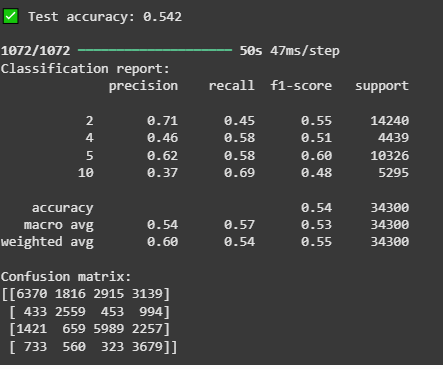